In [1]:
## Computes and plots FFTs of all .csv files in this directory

###TODO: ADD MORE DATA
#TODO: check to make sure means are the same for synthetic and real data

In [2]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import pandas as pd
import glob #allegedly this helps access files
from fft_radarfuncs import *
from lmfit.models import SkewedGaussianModel


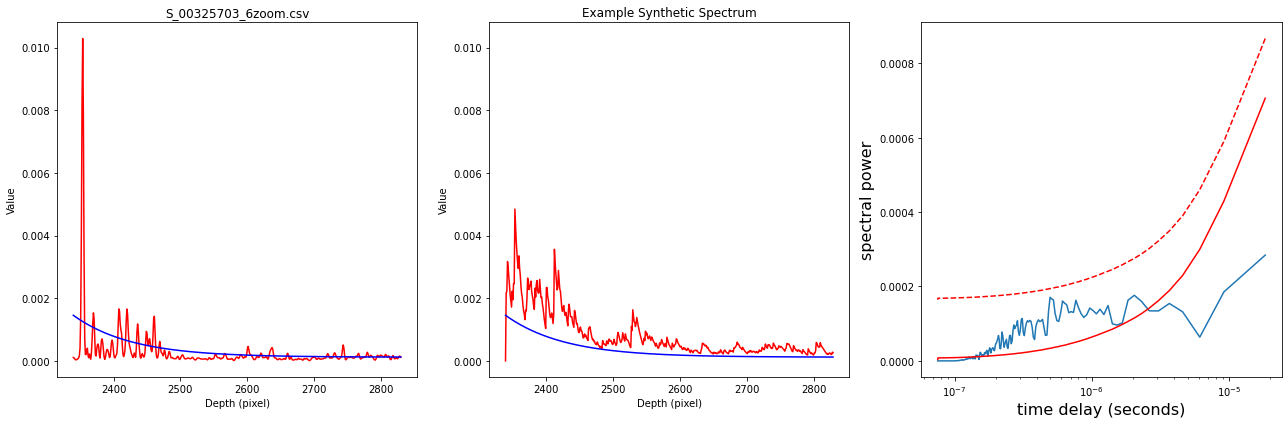

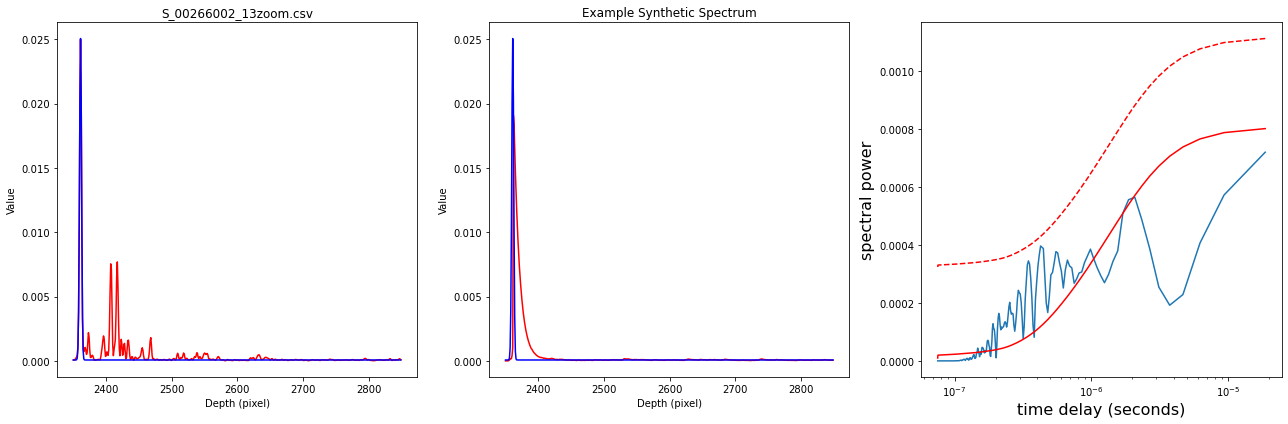

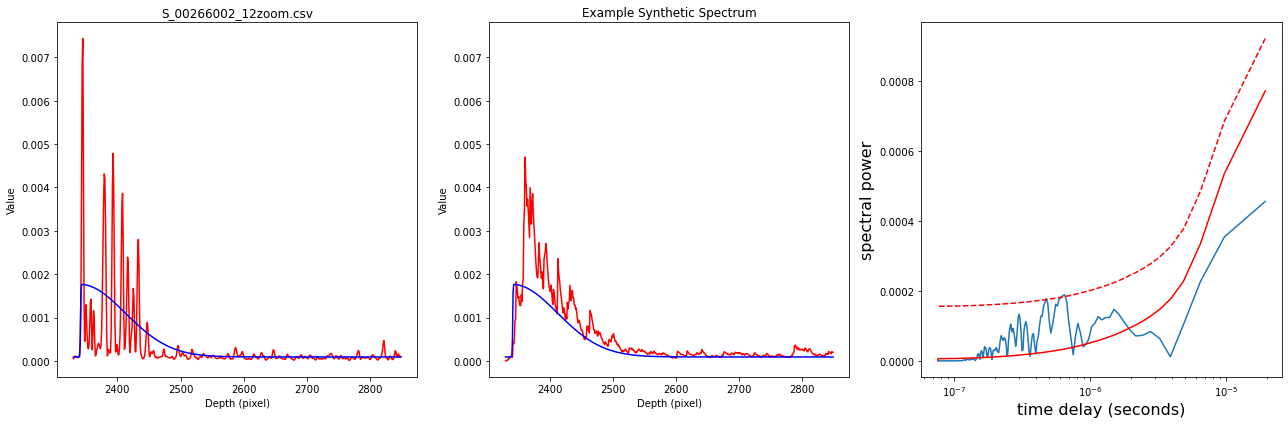

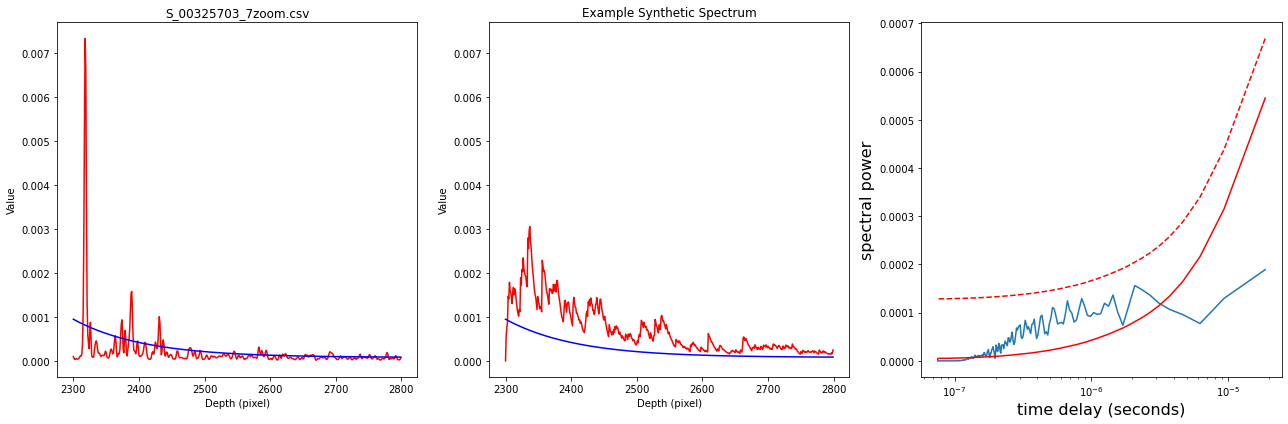

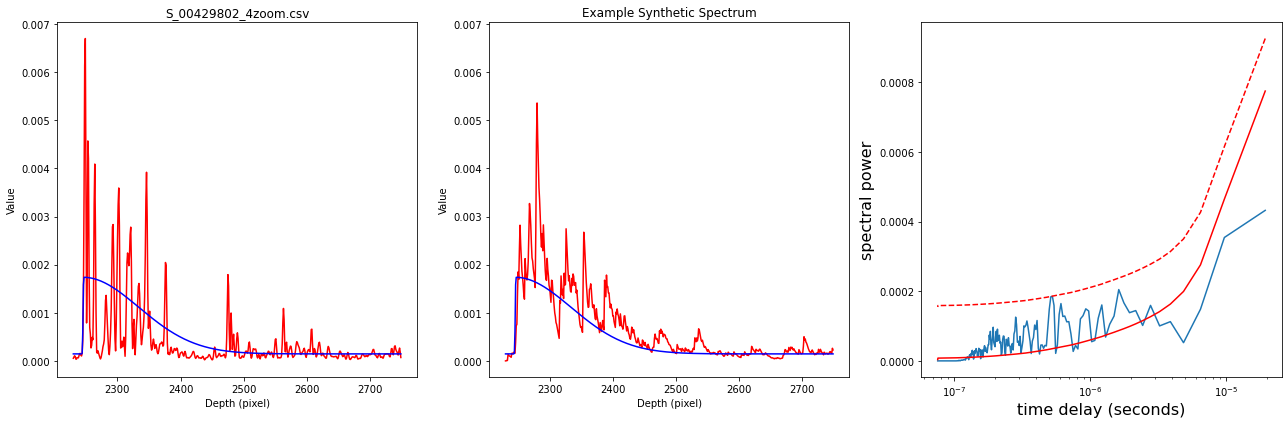

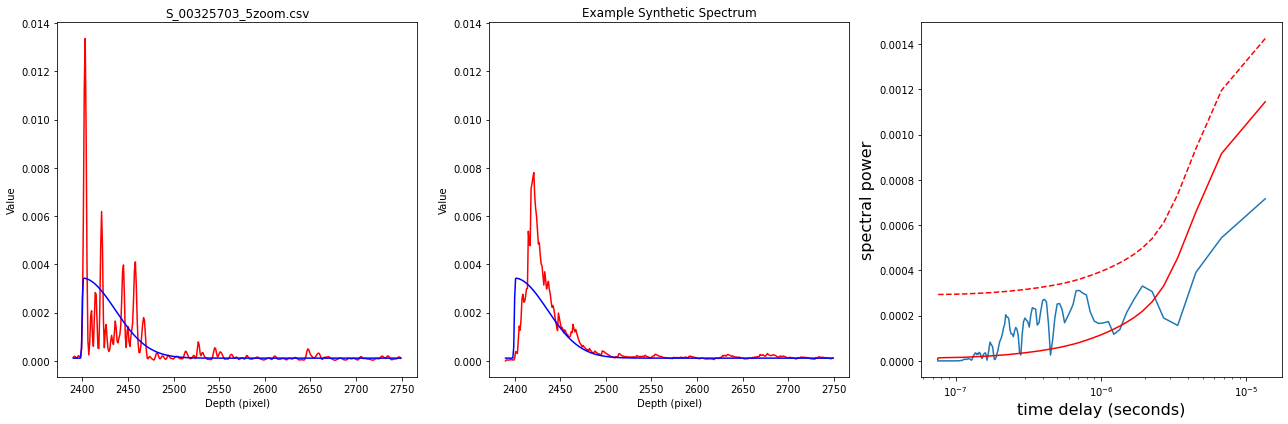

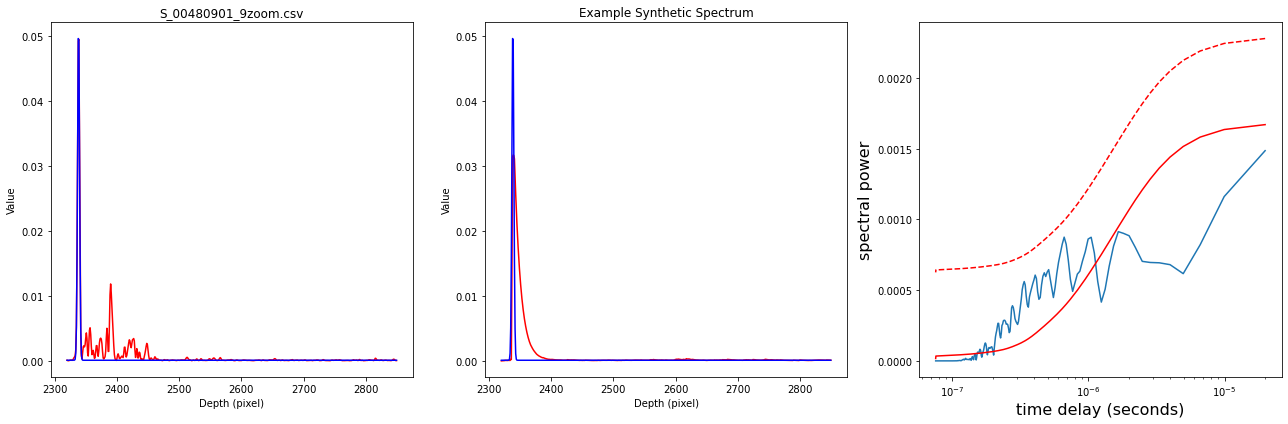

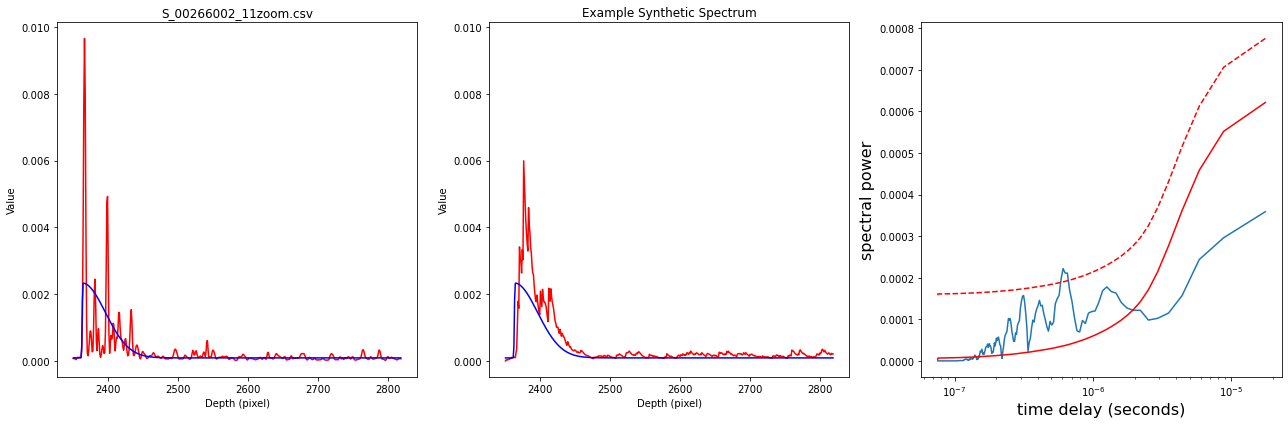

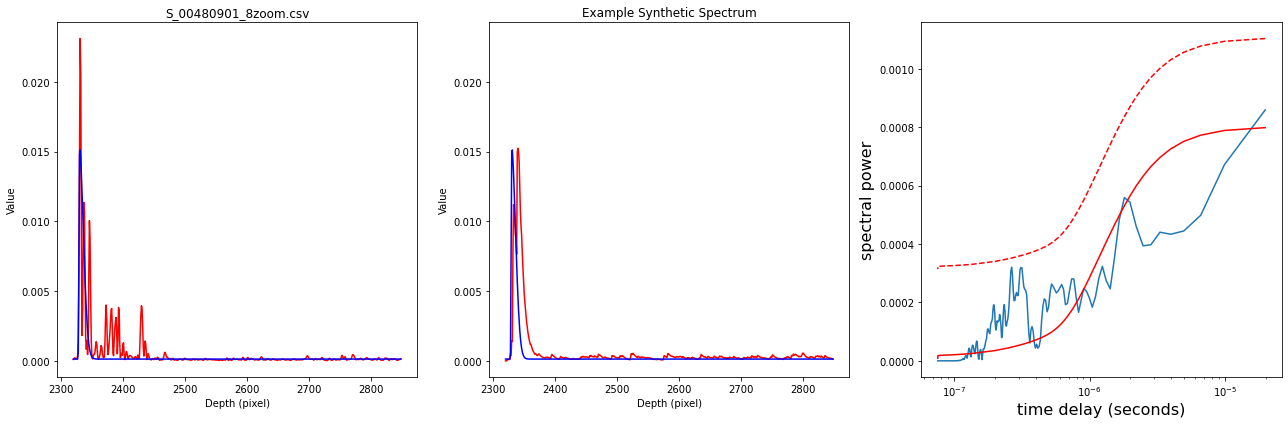

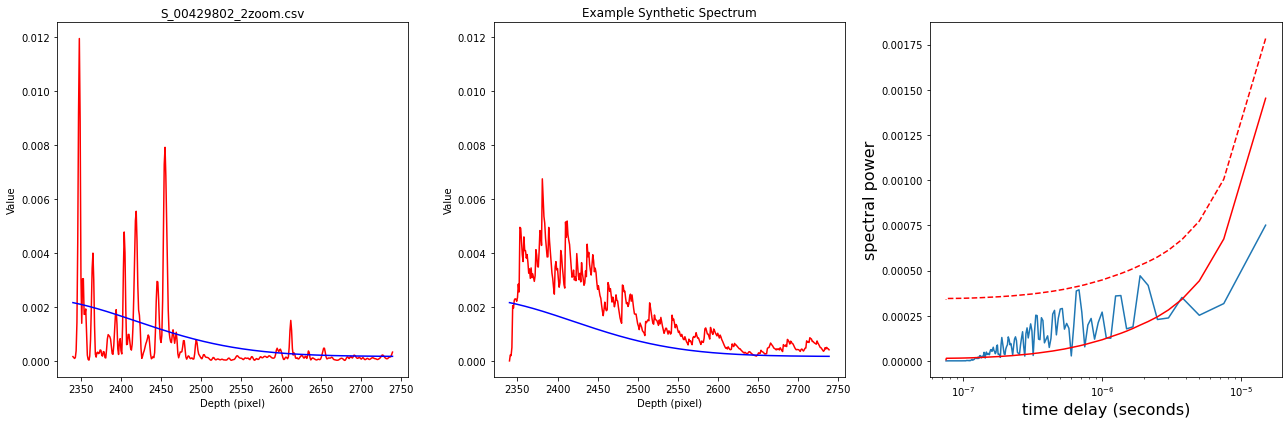

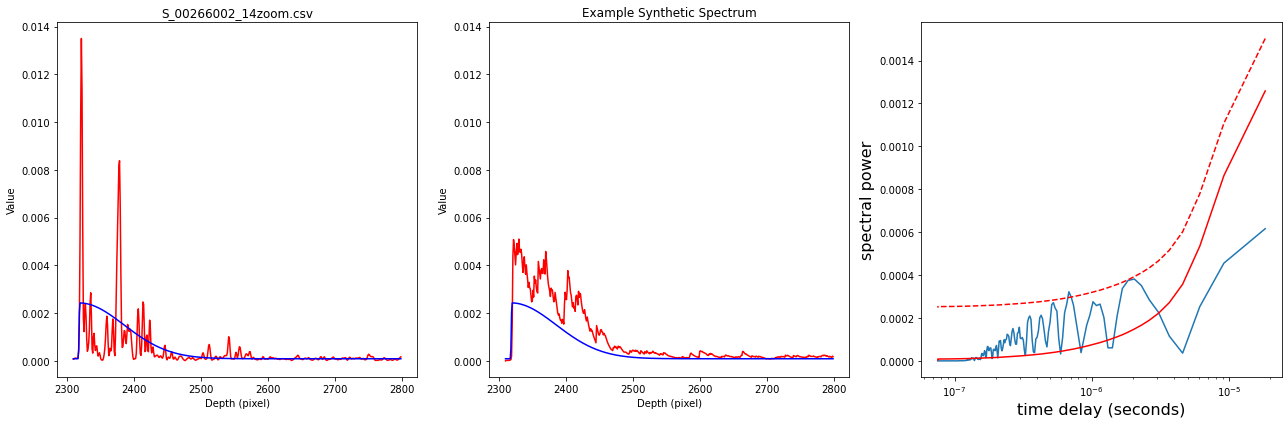

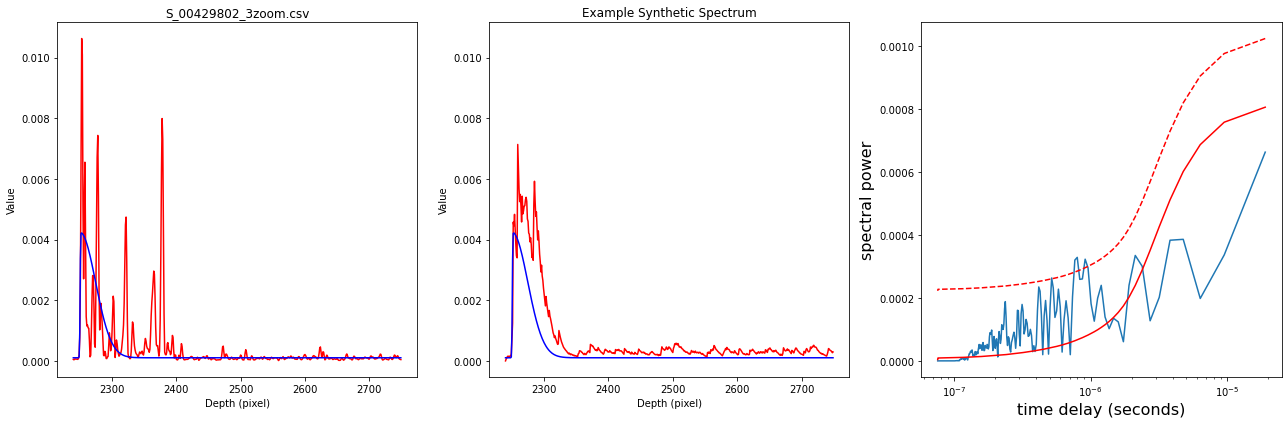

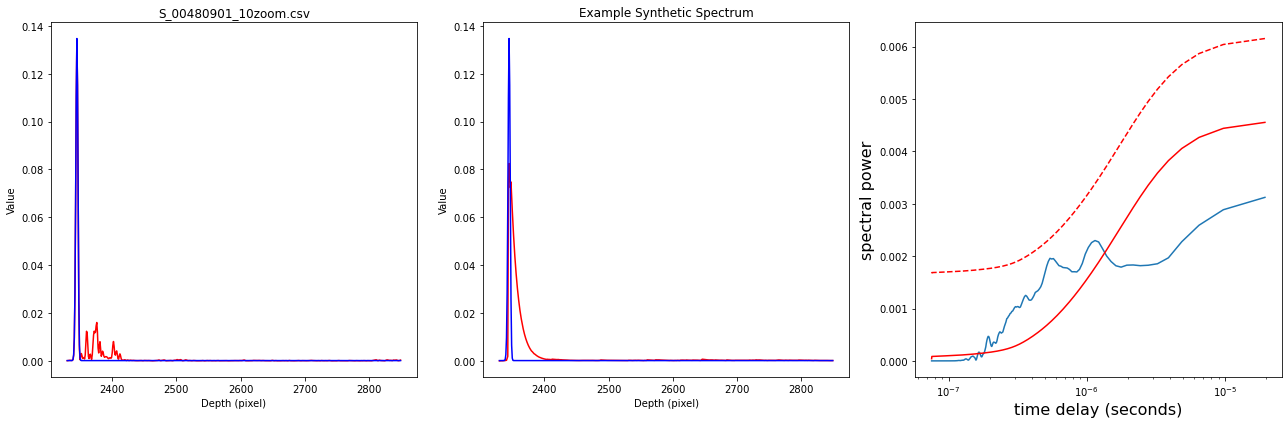

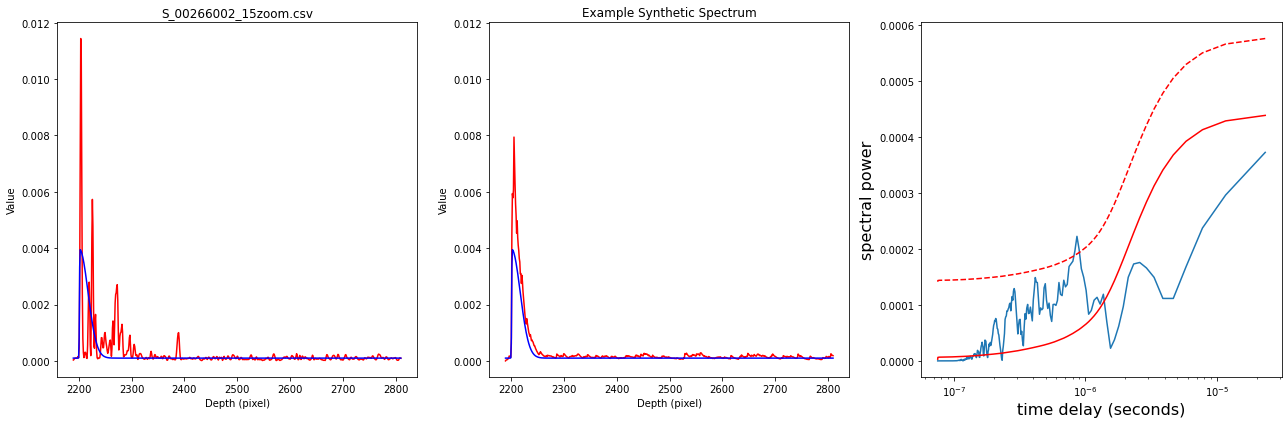

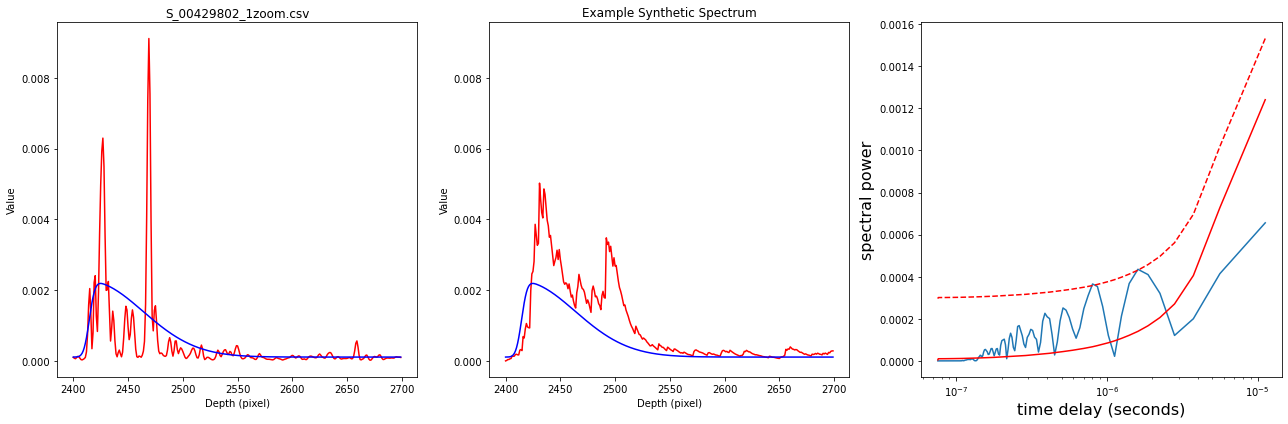

Number of datasets: 15


In [12]:
#Import csv files
csv_import = glob.glob("*zoom.csv")

column_names = ['depth', 'value']
csv_list = []

#compute ffts, add red noise lines to each fft plot
for i in csv_import:
    csv = pd.read_csv(i, names=column_names, skiprows=2)
    csv_list.append(csv)
    
    x = csv.depth.to_list()
    y = csv.value.to_list()
    if len(x) % 2 != 0:
        x.pop()
        y.pop()
    
    
    ##compute line to fit synthetic data to
    # Skewed Gaussian fit
    model = SkewedGaussianModel()
    params = model.make_params(amplitude=(max(y)), center=min(x)+20, sigma=20, gamma=1.5)
    result = model.fit(y, params, x=x)
    fit = result.best_fit +np.mean(y[-150:]) # prevents fit from damping out all of the noise on right-handed side

    
    #convert depth in pixels to depth in seconds (time-delay)
    #SHARAD radargrams are 3.75e-8 seconds per pixel
    deptht = .0000000375*len(x)

    #run fft 
    w, P1 = fft_radar(x,y)
    
    #Compute monte carlo red noise
    ft = [] #holds fourier transforms for each of 20000 random synthetic records
    syn = []

    for a in range(20000):
        r=ar1(x,y,fit) #this creates a random synthetic record with similar properties
        syn.append(r)
        w2, p = fft_radar(x,r)
        ft.append(p)
    
    
    #plot depth plot
    plt.figure(figsize = (18, 6))
    plt1 = plt.subplot(131)
    plt1.plot(x, y, 'r')
    plt1.plot(x, fit, color = 'b')
    plt1.set_title(i)
    plt1.set_ylabel('Value')
    plt1.set_xlabel('Depth (pixel)')

    #plot example synthetic spectra
    plt2 = plt.subplot(132, sharey=plt1)
    plt2.plot(x, syn[0], 'r')
    plt2.plot(x, fit, color = 'b')
    plt2.set_title('Example Synthetic Spectrum')
    plt2.set_ylabel('Value')
    plt2.set_xlabel('Depth (pixel)')

    
    #plot spectrum
    plt3 = plt.subplot(133)
    plt3.plot(w, P1)
    plt3.plot(w,np.mean(ft, axis=0), 'r')
    plt3.plot(w,np.mean(ft, axis=0)+2*np.std(ft),'r',ls='dashed')
    plt3.set_xscale('log')
    plt3.set_xlabel('time delay (seconds)', fontsize=16)
    plt3.set_ylabel('spectral power', fontsize=16) #units are whatever JMARS reports, I have to look into this
    plt.tight_layout()
    plt.show()

print("Number of datasets: " +str(len(csv_list)))
